# Dependencies

In [1]:
import argparse

import os

import time
import torch

import matplotlib.pyplot as plt
import numpy as np

from model.dataloader import HELMETDataLoader
from model.dataloader import class_dict
from model.models import Darknet, load_weights, load_darknet_weights
from utils.utils import *

from IPython.display import clear_output

# Load in model

In [2]:
cfg_path = './cfg/yolov3_36.cfg'
conv74_weights_path = './weights/darknet53.conv.74'
trained_weights_path = './weights/416e17.pt'

In [3]:
# Load in darknet.
def get_darknet(img_size, cfg=cfg_path):
    return Darknet(cfg, img_size)

img_size = 416

model = get_darknet(img_size=img_size)

In [4]:
cuda_enable = False
cuda_available = torch.cuda.is_available()
if cuda_enable and cuda_available:
    device = torch.device('cuda:0')
else:
    device = 'cpu'
print('Using device: ', device)

Using device:  cpu


In [5]:
# load in weights
checkpoint = torch.load(trained_weights_path, map_location=device)
model.load_state_dict(checkpoint)

<All keys matched successfully>

# Dataloader

In [6]:
batch_size = 3

dataloader = HELMETDataLoader("./data/HELMET_DATASET_DUMMY", shuffle=True, batch_size=batch_size, resize=(img_size, img_size))

# Dataloader unit test

In [7]:
batch = next(iter(dataloader))

imgs, targets, annotations = batch

# imgs = imgs[0].reshape(1, 3, img_size, img_size)

out = model(imgs)

print('Img shape:', imgs.shape)
print('Output shape:', out.shape)
print('Targets shape:', targets[0].size())

Img shape: torch.Size([3, 3, 416, 416])
Output shape: torch.Size([3, 10647, 41])
Targets shape: torch.Size([5, 5])


In [8]:
model.to(device).eval()
targets = list(map(lambda x: x.type(torch.FloatTensor), targets))
loss = model(imgs.to(device), targets)

# loss, model.losses

C:\Users\runes\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


# Test the model

### Detection hyperparamaters

In [9]:
opt = {
    'conf_thres': .4,  # Confidence threshold.
    'nms_thres': .45,   # Non-max supression.
    'iou_thres': 0.5   # IoU
}

### Make predictions

In [10]:
model.to(device).eval()
img_detections = []

# Get detections
for img in imgs:
    with torch.no_grad():
        pred = model(img.to(device).reshape(1, 3, img_size, img_size)) # pred = model(chip)
        pred = pred[pred[:, :, 4] > opt['conf_thres']]

        if len(pred) > 0:
            detections = non_max_suppression(pred.unsqueeze(0), opt['conf_thres'], opt['nms_thres'])
            img_detections.extend(detections)

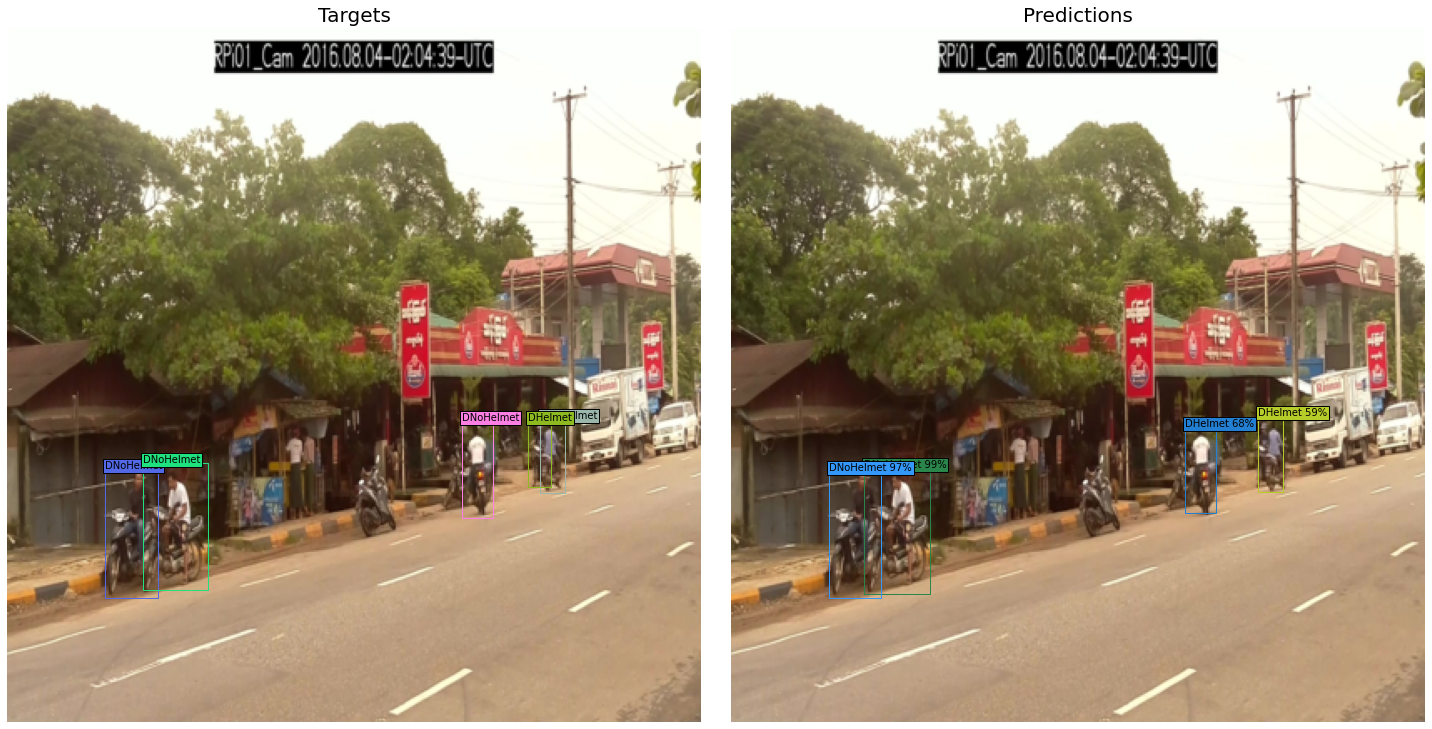

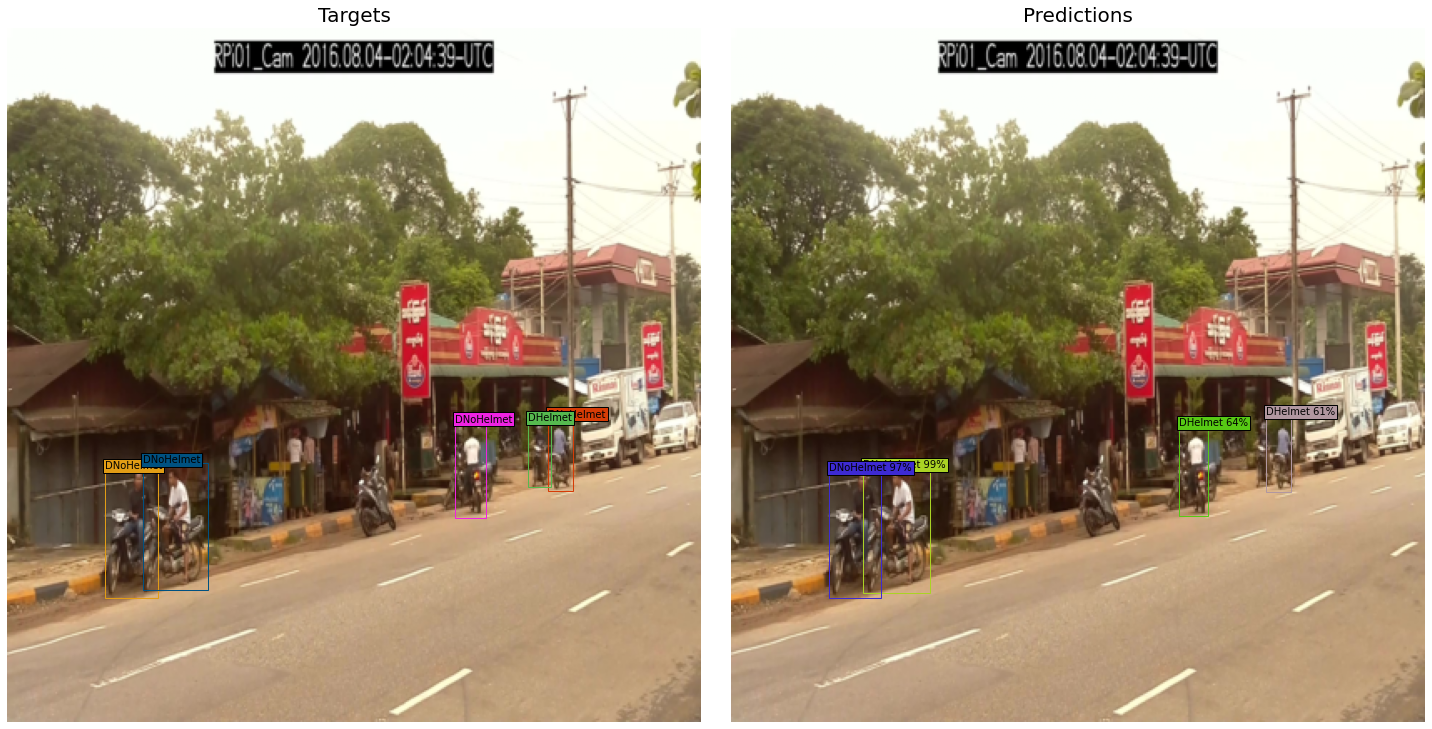

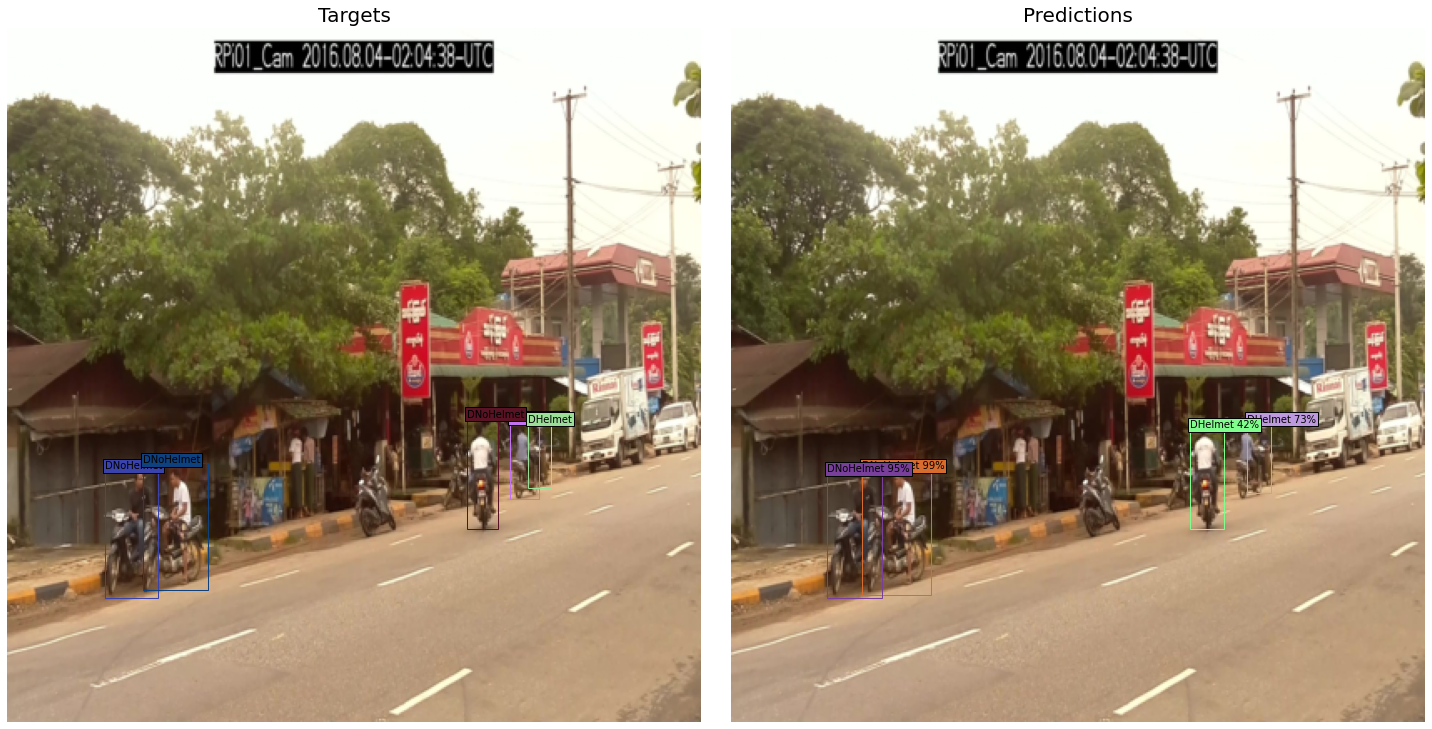

In [12]:
for img, target, detection in zip(imgs, targets, img_detections):
    # Figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)

    ax1.imshow(np.array(img).transpose([1, 2, 0]))
    ax2.imshow(np.array(img).transpose([1, 2, 0]))
    ax1.axis('off')
    ax2.axis('off')
    ax1.set_title('Targets', fontsize=20)
    ax2.set_title('Predictions', fontsize=20)

    for label, x1, y1, box_w, box_h in target:
        # Rescale coordinates to original dimensions
        box_h = (box_h * img.shape[1]).item()
        box_w = (box_w * img.shape[2]).item()
        y1 = (y1 * img.shape[1] - box_h / 2).round().item()
        x1 = (x1 * img.shape[2] - box_w / 2).round().item()

        x1, y1 = max(x1, 0), max(y1, 0)

        label = list(class_dict.keys())[int(label)]
        col = tuple(np.random.random(3))
        rect = plt.Rectangle((x1, y1), box_w, box_h, fc="none", ec=col)
        ax1.add_patch(rect)
        ax1.text(x1, y1, label, fontsize=10, bbox={'facecolor': col, 'pad': 2})
    
    # Draw bounding boxes and labels of detections
    if detection is not None:
        unique_classes = detection[:, -1].cpu().unique()

        for i in unique_classes:
            n = (detection[:, -1].cpu() == i).sum()
            # print('%g %ss' % (n, classes[int(i)]))

        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detection:
            if len(class_dict.keys()) < int(cls_pred) - 1:
                continue

            # Rescale coordinates to original dimensions
            box_h = (y2 - y1) 
            box_w = (x2 - x1)
            
            label = list(class_dict.keys())[int(cls_pred)]
            col = tuple(np.random.random(3))
            rect = plt.Rectangle((x1, y1), box_w, box_h, fc="none", ec=col)
            ax2.add_patch(rect)
            ax2.text(x1, y1, label + ' ' + str( round(conf.item() * 100) ) + '%', 
                     fontsize=10, bbox={'facecolor': col, 'pad': 2})
    plt.show()

# Metrics

In [ ]:
print('Compute mAP...')
correct = 0
targets = None
outputs, mAPs, TP, confidence, pred_class, target_class = [], [], [], [], [], []
for batch_i, (imgs, targets, annotations) in enumerate(dataloader):
    imgs = imgs.to(device)
    targets = list(map(lambda x: x.type(torch.FloatTensor), targets))
    with torch.no_grad():
        output = model(imgs)
        output = non_max_suppression(output, conf_thres=opt['conf_thres'], nms_thres=opt['nms_thres'])

    # Compute average precision for each sample
    for sample_i in range(len(targets)):
        correct = []

        # Get labels for sample where width is not zero (dummies)
        annotations = targets[sample_i]
        # Extract detections
        detections = output[sample_i]

        if detections is None:
            # If there are no detections but there are annotations mask as zero AP
            if annotations.size(0) != 0:
                mAPs.append(0)
            continue

        # Get detections sorted by decreasing confidence scores
        detections = detections[np.argsort(-detections[:, 4])]

        # If no annotations add number of detections as incorrect
        if annotations.size(0) == 0:
            target_cls = []
            #correct.extend([0 for _ in range(len(detections))])
            mAPs.append(0)
            continue
        else:
            target_cls = annotations[:, 0]

            # Extract target boxes as (x1, y1, x2, y2)
            target_boxes = xywh2xyxy(annotations[:, 1:5])
            target_boxes *= img_size

            detected = []
            for *pred_bbox, conf, obj_conf, obj_pred in detections:

                pred_bbox = torch.FloatTensor(pred_bbox).view(1, -1)
                # Compute iou with target boxes
                iou = bbox_iou(pred_bbox, target_boxes)
                # Extract index of largest overlap
                best_i = np.argmax(iou)
                # If overlap exceeds threshold and classification is correct mark as correct
                if iou[best_i] > opt['iou_thres'] and obj_pred == annotations[best_i, 0] and best_i not in detected:
                    correct.append(1)
                    detected.append(best_i)
                else:
                    correct.append(0)

        # Compute Average Precision (AP) per class
        AP = ap_per_class(tp=correct, conf=detections[:, 4], pred_cls=detections[:, 6], target_cls=target_cls)

        # Compute mean AP for this image
        mAP = AP.mean()

        # Append image mAP to list
        mAPs.append(mAP)

        # Print image mAP and running mean mAP
        print('+ Sample [%d/%d] AP: %.4f (%.4f)' % (len(mAPs), len(dataloader) * batch_size, mAP, np.mean(mAPs)))

print('Mean Average Precision: %.4f' % np.mean(mAPs))